# 1D diffusion model using Numpy

This notebook demonstrates some of Numpy's capabilities by showing how you can use it to build a numerical model of heat diffusion in permafrost.

(Greg Tucker, for Computational Tools class, Oct 2018)

## Problem setup

### Conductive heat flow in soil

We would like to calculate the temperature in the ground over time, in response to daily and annual cycles of surface temperature. We will assume that all heat flow occurs by conduction (and not, for example, by infiltrating water), that the thermal properties of the soil are constant, and that there are no internal heat sources or sinks (such as phase changes or radioactive heat production). We will also assume that the temperature is uniform in the horizontal, such that the problem is 1D (heat flow occurs only vertically).

### Governing equation

Under these conditions, the governing equation is:

$\frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial z^2}$

where $T$ is temperature at depth $z$, $t$ is time, and $\kappa$ is thermal diffusivity (in units of m$^2$/s).

### Finite-difference approximation

A finite-difference approximation of the above governing equation is:

$\frac{T_i^{k+1} - T_i^k}{\Delta t} = \frac{\kappa}{\Delta z^2} \left( T_{i+1}^k - 2 T_i^k + T_{i-1}^k \right)$

Here, we have divided the domain into a set of horizontal soil layers, each of which has thickness $\Delta z$. We'll refer to the center point in each layer as a *node*. Nodes will be numbered from top to bottom, starting with node 0, which represents the surface temperature. Time will be divided into a series of *time steps* of duration $\Delta t$. The superscript indicates the time step, and the subscript indicates the node number. Therefore, $T_i^k$ means temperature at node $i$ at time step $k$.

This describes an *explicit* finite-difference method, because the temperature at the next time step is explicitly determined by the temperature at the same node and its two neighbors at the current time step. To see this, rearrange the above:

$T_i^{k+1} = T_i^k + \frac{\kappa \Delta t}{\Delta z^2} \left( T_{i+1}^k - 2 T_i^k + T_{i-1}^k \right)$

So, our job is set an initial temperature value at each node, and then iterate through a series of time steps, updating the temperature values along the way. First, though, let's think about *boundary conditions.*

### Boundary conditions

The temperature at the topmost node (node 0) will represent surface temperature. We will prescribe this value (ultimately, we want it to evolve over the course of a day and/or year). So we will use a fixed-value boundary condition at the top. For the bottom, it makes sense to assume that there is no flow of heat in or out. This is a fixed gradient boundary condition. A simple way to ensure this is to make the temperature of the bottom node (which is node $N-1$ if there are $N$ nodes) is always equal to that of its immediate neighbor ($N-2$).

## Parameters and data structures

We'll use a Numpy array for our temperature values. We also need variables for $\Delta t$ (call it ``dt``), $\Delta z$ (``dz``), $N$, and $\kappa$ (``kappa``). First, some imports...

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now, define parameters:

In [10]:
N = 101  # number of nodes
dz = 0.05  # node spacing (m)
kappa = 1.0e-6  # thermal diffusivity (m2/s)
run_duration = 10   # run duration (days)
initial_temperature = 10.0  # starting temperature (deg C)
mean_temperature = 10.0    # mean surface temperature (deg C)
diurnal_temp_range = 5.0   # diurnal temperature half-range (deg C)
period = 24.0 * 3600.0     # period of surface temp variation (s)
plot_interval = 0.5 * 3600.0  # plot interval (s)
plot_name = 'temp_profile' # base name for plot files

Set up an array for temperature:

In [11]:
temp = np.zeros(N) + initial_temperature

Define time step size using CFL condition, and calculate the number of time steps (including conversion of run duration from days to seconds):

In [12]:
dt = 0.2 * dz * dz / kappa
num_time_steps = int(24 * 3600.0 * run_duration / dt)

Make an array called ``inner`` with all the node indices *except* top and bottom.

In [13]:
inner = np.arange(1, N-2)  # indices of inner nodes

Define handy lumped variable:

In [14]:
alpha = kappa * dt / (dz * dz)

In [15]:
def plot_temp_profile(temp, depth, filename=None):
    """Plot the temperature profile."""
    plt.clf()
    plt.plot(temp, z)
    plt.gca().invert_yaxis()
    plt.xlabel('TEMPERATURE (deg C)')
    plt.ylabel('DEPTH (m)')
    plt.xlim([mean_temperature - diurnal_temp_range,
              mean_temperature + diurnal_temp_range])
    
    if filename is not None:
        plt.savefig(filename)

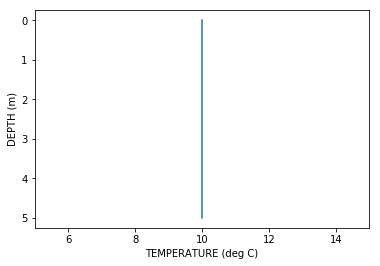

In [16]:
next_plot = plot_interval
z = np.arange(N) * dz
plt.clf()
plot_temp_profile(temp, z, plot_name + '0000.png')

## Main loop

In [57]:
for i in range(num_time_steps):
    
    # Update the surface temperature
    temp[0] = (mean_temperature
               + diurnal_temp_range * np.sin(2.0 * np.pi * i * dt / period))
    
    # Set lowest node temp equal to that of its neighbor
    temp[-1] = temp[-2]
    
    # Update the inner-node temperature field
    temp[inner] += (alpha
                    * (temp[inner+1] - 2 * temp[inner] + temp[inner-1]))
    
    # Plot
    if i * dt >= next_plot:
        # plot_temp_profile(temp, z, plot_name + str(i).zfill(4) + '.png')
        next_plot += plot_interval

In [46]:
period

86400.0

In [47]:
num_time_steps

1727